In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline

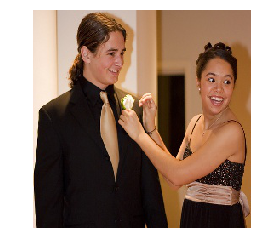

In [125]:
img = cv2.imread('../dataset/val_dataset_256//000000011051.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
mask = cv2.imread('../dataset/val_dataset_256//000000011051_mask.jpg', 0)
plt.axis('off')
plt.imshow(img)

In [126]:
def augment_brightness(image):
    rand_brightness = .25 + np.random.uniform()
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image[:,:,2] = image[:,:,2]*rand_brightness
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image

def change_contrast(img):
    factor = (255 - 100 * np.random.uniform()) / (255 + 100 * np.random.uniform())
    def contrast(c):
        return 128 + factor * (c - 128)
    return contrast(img).astype(np.uint8)

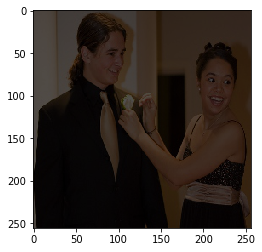

In [127]:
img_augmented_brightness = augment_brightness(img)
plt.imshow(img_augmented_brightness)

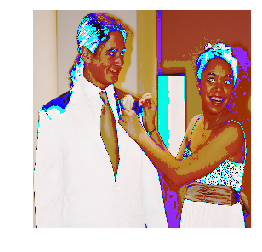

In [128]:
img_changed_contrast = change_contrast(img)
plt.axis('off')
plt.imshow(img_changed_contrast)

In [131]:
def augment_translation(image, mask, trans_range):
    assert image.shape[:-1] == mask.shape
    
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    tr_y = trans_range * np.random.uniform() - trans_range / 2
    trans_M = np.array([[1, 0, tr_x], [0, 1, tr_y]], dtype=np.float32)
    width, height, _ = image.shape
    image = cv2.warpAffine(image, trans_M, (width, height))
    mask = cv2.warpAffine(mask, trans_M, (width, height))
    return image, mask

(256, 256, 3)

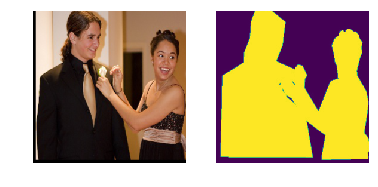

In [132]:
img_augmented_trans, mask_augmented_trans = augment_translation(img, mask, np.random.normal(50, 25))
plt.subplot(1,2,1)
plt.imshow(img_augmented_trans)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask_augmented_trans)
plt.axis('off')
img_augmented_trans.shape

In [135]:
def augment_stretch_image(img, mask, scale_range):
    assert img.shape[:-1] == mask.shape
    
    tr_x1 = scale_range*np.random.uniform()
    tr_y1 = scale_range*np.random.uniform()
    p1 = (tr_x1,tr_y1)
    tr_x2 = scale_range*np.random.uniform()
    tr_y2 = scale_range*np.random.uniform()
    p2 = (img.shape[0]-tr_x2,tr_y1)
    
    p3 = (img.shape[0]-tr_x2,img.shape[1]-tr_y2)
    p4 = (tr_x1,img.shape[1]-tr_y2)

    pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
    pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],
                   [0,img.shape[0]] ]
                   )
    
    M = cv2.getPerspectiveTransform(pts1,pts2)
    img = cv2.warpPerspective(img,M,(img.shape[0],img.shape[1]))
    img = np.array(img,dtype=np.uint8)
    mask = cv2.warpPerspective(mask,M,(mask.shape[0],mask.shape[1]))
    mask = np.array(mask,dtype=np.uint8)
    
    return img, mask

(-0.5, 255.5, 255.5, -0.5)

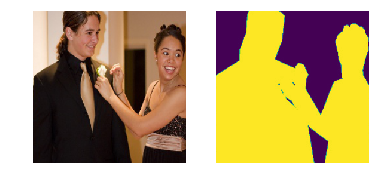

In [136]:
img_augmented_stretch, mask_augmented_stretch = augment_stretch_image(img, mask, np.random.normal(30, 10))
plt.subplot(1,2,1)
plt.imshow(img_augmented_stretch)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask_augmented_stretch)
plt.axis('off')

In [157]:
def elastic_transform(image, mask, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
     Source: https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    mask = cv2.warpAffine(mask, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))
    
    image = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    print(shape)
    print(len(indices))
    print(map_coordinates(mask, indices[:2], order=1, mode='reflect').shape)
    mask = map_coordinates(mask, indices[:2], order=1, mode='reflect').reshape(shape[:-1])

    return image, mask

In [158]:
rnd_nr = lambda a, b: np.random.normal(a, b)
elastic_trans_img, elastic_trans_mask = elastic_transform(img, mask, rnd_nr(40, 30), rnd_nr(40, 30), rnd_nr(30, 20))
plt.subplot(1,2,1)
plt.imshow(elastic_trans_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(elastic_trans_mask)
plt.axis('off')

(256, 256, 3)
3
(196608, 1)


ValueError: cannot reshape array of size 196608 into shape (256,256)

In [44]:
from albumentations.augmentations.transforms import ElasticTransform

(-0.5, 255.5, 255.5, -0.5)

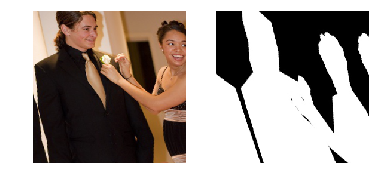

In [56]:
elatic_transformation = ElasticTransform()
elast_img = elatic_transformation.apply(img)
elast_mask = elatic_transformation.apply_to_mask(mask)
plt.subplot(1,2,1)
plt.imshow(elast_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(elast_mask)
plt.axis('off')

In [64]:
img_augmented_brightness.dtype == np.dtype('uint8')

True

In [95]:
def blur(image):
    """Mirror reflection of an input image

    :return: image
    """

    return cv2.blur(image, (5, 5))

dtype('uint8')

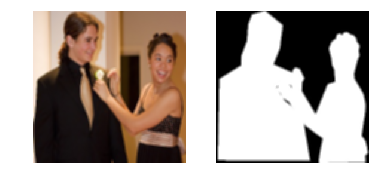

In [121]:
img_blur = blur(img)
mask_blur = blur(mask)
plt.subplot(1,2,1)
plt.imshow(img_blur)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask_blur)
plt.axis('off')
img_blur.dtype

In [100]:
def mirror(image):
    return cv2.flip(image, 1)

(1, 256, 256)

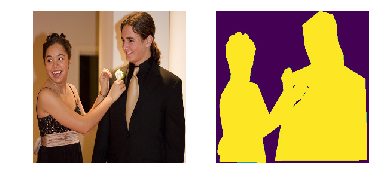

In [162]:
img_mirror = mirror(img)
mask_mirror = mirror(mask)
plt.subplot(1,2,1)
plt.imshow(img_mirror)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask_mirror)
plt.axis('off')
img_mirror.dtype
mask_mirror.shape
np.expand_dims(mask_mirror, axis=0).shape